In [1]:
import os
os.chdir(os.getcwd() + '/../../')

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

from scripts.utils import *
from scripts.SpectralClustering import *

# Q2

In [3]:
A = np.array([[0, 1, 1, 0, 0],
              [1, 0, 1, 0, 0],
              [1, 1, 0, 0, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 1, 0]])
            
D = np.diag(A.sum(axis=1).flatten())
            
# graph Laplacian
L = D - A
            
# decomposition
v, x = np.linalg.eig(L)
v = v.real
x = x.real

print('graph Laplacian matrix:')
print(L)

print('\neigenvalues:')
print(v)

graph Laplacian matrix:
[[ 2 -1 -1  0  0]
 [-1  2 -1  0  0]
 [-1 -1  2  0  0]
 [ 0  0  0  1 -1]
 [ 0  0  0 -1  1]]

eigenvalues:
[ 3.00000000e+00 -4.23796137e-16  3.00000000e+00  2.00000000e+00
  0.00000000e+00]


0 eigenvalue has 2 multiplicity at index 1 and 4. Therefore number of clusters is 2. This can be seen also from the presence of 2 blocks in connectivity matrix A. And if we arrange the corresponding eigenvectors:

In [4]:
x[:, [1, 4]]    # eigenvectors associated with 0 eigenvalues

array([[-0.57735027,  0.        ],
       [-0.57735027,  0.        ],
       [-0.57735027,  0.        ],
       [ 0.        ,  0.70710678],
       [ 0.        ,  0.70710678]])

We can see datapoints 0, 1, 2 (corresponding to node 1, 2, 3 in the question) belong to one cluster and the rest, another cluster.

# Football team clustering based on league play-graph

This notebook runs spectral clustering on football league play-graph.
Clustering results with different k are saved in **'/results/football_team_clustering/'** folder

In [5]:
a = import_graph('data/football/play_graph.txt')
a = a-1
a[:5]

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

play-graph a is a 2D array where each row indicates team_id in column 1 played team_id in column 2.

In [6]:
# initialize SpectralClust class
spectral = SpectralClust(a)

## 1. Eigenvalues plot

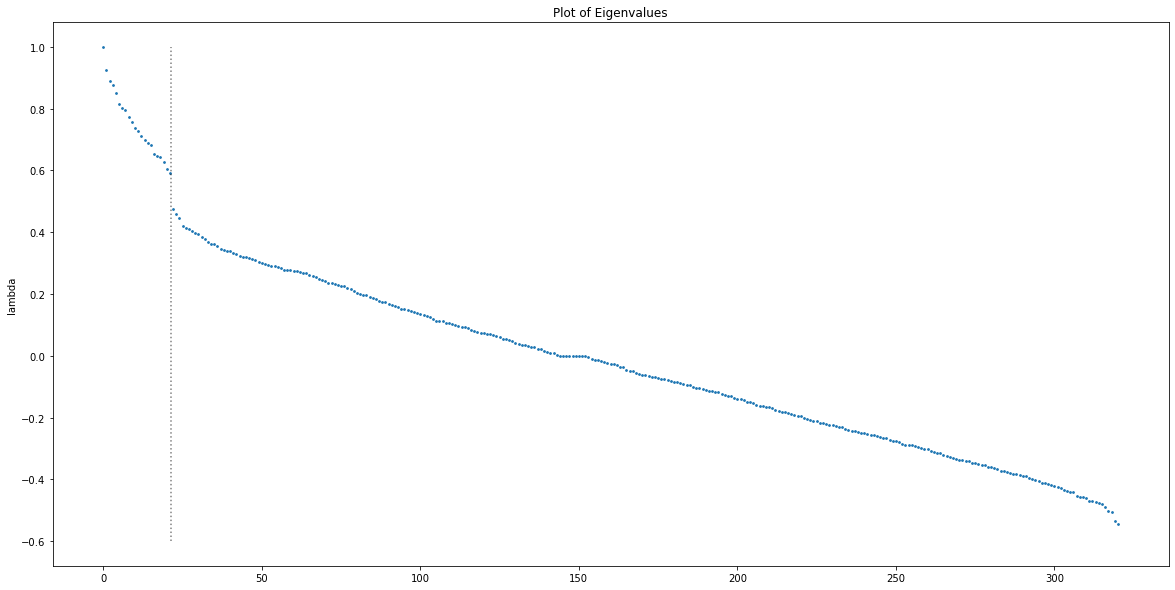

In [7]:
spectral.construct_similarity_matrix(plot_eigenvalues=True, figsize=(20, 10))
plt.vlines(21.5, ymin=-0.6, ymax=1, colors='black', linestyles='dotted', alpha=0.5)

Eigenvalues plot shows sharp cutoff at 22 values, a strong evidence of the presence of 22 clusters in the dataset. The plot visualizes connectivity between clusters and in general first k eigenvalues are selected that maximizes the eigengap. The intuition is, well-defined eigengap corresponds to well-defined clusters (with stark difference between intercluster connectivity and intracluster connectivity). Although some clustering problems will have poorly-defined similarity within clusters which will result in relatively smooth eigenvalues plot and the need to use more sophisticated method, in this football team clustering case, number of cluster can be derived using eigengap method.

## 2. Different values of k

### 2.1. Asigned clusters for each node

Assigned clusters for different value of k can be found in **'/results/football_team_clustering/'** folder with their corresponding filenames.

In [8]:
K = [5, 7, 10, 22]
n_repeats = 10
rng = np.random.default_rng(0)
best_results_list = []
for k in K:
    best_results_list.append(spectral.run_clustering(k, n_repeats, rng=rng, verbose=False)['best_result'])
    
df_best_results = pd.DataFrame(best_results_list)
df_best_results['k'] = K

df_best_results.head()

,clusters,centroids,closest_centroids,loss,initialization_time,optimization_time,iterations,k
0,"[2, 2, 2, 4, 4, 4, 3, 4, 4, 4, 2, 2, 0, 0, 4, ...","[[-0.06046351655345556, 0.11815336708265124, 0...","[[-0.05670445499375304, -0.0518598687808655, 0...",1.240332,0.015625,0.000000,6,5
1,"[1, 5, 1, 6, 6, 6, 4, 6, 4, 6, 4, 1, 3, 3, 6, ...","[[-0.0390576621436381, 0.06495519614449481, -0...","[[-0.05909347279734633, -0.05544581126899997, ...",2.055875,0.015625,0.000000,16,7
2,"[0, 7, 0, 0, 0, 0, 9, 4, 5, 4, 9, 0, 1, 6, 4, ...","[[-0.05527812331812012, -0.03693667270532918, ...","[[-0.05527812331812012, -0.03693667270532918, ...",2.724288,0.031250,0.015625,16,10
3,"[11, 3, 11, 2, 12, 7, 4, 16, 5, 6, 18, 11, 17,...","[[-0.06264290399188291, -0.037091650204747424,...","[[-0.0619155704642075, -0.057839666132939026, ...",3.889151,0.156250,0.015625,8,22


In [9]:
# output files
idx2name = read_team_name('data/football/inverse_teams.txt')

dirpath = 'results/football_team_clustering/'

for k in K:
    output_file(a, 
                idx2name,
                df_best_results.loc[df_best_results['k'] == k, 'clusters'].iloc[0],
                dirpath+'nodes_k'+str(k)+'.csv',
                dirpath+'edges_k'+str(k)+'.csv')

### 2.2. Smallest and largest clusters

In [10]:
def highest_count(arr):
    count = np.bincount(arr)
    return np.max(count)

def lowest_count(arr):
    count = np.bincount(arr)
    return np.min(count)

df_best_results['largest_cluster_size'] = df_best_results['clusters'].apply(highest_count)
df_best_results['smallest_cluster_size'] = df_best_results['clusters'].apply(lowest_count)
df_best_results[['k', 'largest_cluster_size', 'smallest_cluster_size']]

,k,largest_cluster_size,smallest_cluster_size
0,5,168,10
1,7,110,10
2,10,77,10
3,22,51,7


## 3. Consistency between repeats

In [11]:
df_k10 = pd.DataFrame({'label': idx2name})
for i in range(n_repeats):
    results = spectral.run_clustering_once(10, rng=np.random.default_rng(i))
    df_k10[f"iteration_{i+1}"] = results['clusters']

Georgia Tech, Georgia State and Georgia teams are used to evaluate consistency across different iterations:

In [12]:
df_k10[df_k10['label'].isin(['Georgia Tech', 'Georgia State', 'Georgia'])]

,label,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9,iteration_10
3,Georgia State,5,2,8,2,3,3,4,7,9,0
95,Georgia Tech,5,2,8,2,3,3,4,7,9,0
143,Georgia,5,2,8,2,3,3,4,7,9,0


The three teams are clustered in the same team 10 out of 10 iterations. Different cluster assignments can happen when the algorithm is initialized differenty (randomly).

## Additional remarks

In this analysis, kmeans++ is used as a default method of initialization of centroids proposed in 2007 by David Arthur and Sergei Vassilvitskii (https://en.wikipedia.org/wiki/K-means%2B%2B). 

Random_partition method of initialization (where each datapoints are randomly assigned one of the k clusters whose centroids act as the initial centroids) is considered a poor initialization method because most of the time, initial centroids are located in the interior of dataspace. From the 10 iterations spectral clustering with the same seeds, two put Georgia Tech in different cluster from Georgia State and Georgia. This can of course be due to randomness.

In [13]:
df_k10 = pd.DataFrame({'label': idx2name})
for i in range(n_repeats):
    results = spectral.run_clustering_once(10, init_method='random_partition', rng=np.random.default_rng(i))
    df_k10[f"iteration_{i+1}"] = results['clusters']
df_k10[df_k10['label'].isin(['Georgia Tech', 'Georgia State', 'Georgia'])]

,label,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9,iteration_10
3,Georgia State,7,0,3,8,9,7,3,2,5,1
95,Georgia Tech,5,0,3,8,9,2,3,2,5,1
143,Georgia,7,0,3,8,9,7,3,2,5,1


and just for completeness, the other two initialization methods provided in the script are explored

In [14]:
df_k10 = pd.DataFrame({'label': idx2name})
for i in range(n_repeats):
    results = spectral.run_clustering_once(10, init_method='random_data', rng=np.random.default_rng(i))
    df_k10[f"iteration_{i+1}"] = results['clusters']
df_k10[df_k10['label'].isin(['Georgia Tech', 'Georgia State', 'Georgia'])]

,label,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9,iteration_10
3,Georgia State,7,0,0,2,8,9,6,9,8,6
95,Georgia Tech,7,0,0,2,8,9,3,9,8,6
143,Georgia,7,0,0,2,8,9,6,9,8,6


In [15]:
df_k10 = pd.DataFrame({'label': idx2name})
for i in range(n_repeats):
    results = spectral.run_clustering_once(10, init_method='random_uniform', rng=np.random.default_rng(i))
    df_k10[f"iteration_{i+1}"] = results['clusters']
df_k10[df_k10['label'].isin(['Georgia Tech', 'Georgia State', 'Georgia'])]

,label,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9,iteration_10
3,Georgia State,6,3,2,8,3,1,7,9,5,9
95,Georgia Tech,6,3,2,8,3,1,7,9,5,9
143,Georgia,6,3,2,8,3,1,7,9,5,9


In general, the three initialization methods with k=10 yield expected results that the three mentioned teams are in the same cluster.